## 1) Entorno y rutas
Comprobamos rutas y dependencias. Si falta alguna librería, instalar con `pip` desde el propio kernel (ejecuta la celda si necesitas instalar).

In [1]:
# Ajusta estas rutas si tu workspace es distinto
from pathlib import Path
ROOT = Path.cwd()
DATA_DIR = ROOT / 'data' / 'student_nodes'
NB_DIR = DATA_DIR / 'notebook_rl'
RESULTS_DIR = NB_DIR / 'results'
FIGS_DIR = NB_DIR / 'figs'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGS_DIR.mkdir(parents=True, exist_ok=True)
print('ROOT =', ROOT)
print('DATA_DIR =', DATA_DIR)
print('Predictions file exists:', (DATA_DIR / 'dcrnn_predictions_demo.npz').exists())
print('Test file exists:', (DATA_DIR / 'test.npz').exists())

ROOT = /home/rlara/trabajo_rl/DCRNN_predecir_adj_dina/data/student_nodes/notebook_rl
DATA_DIR = /home/rlara/trabajo_rl/DCRNN_predecir_adj_dina/data/student_nodes/notebook_rl/data/student_nodes
Predictions file exists: False
Test file exists: False


## 2) Importar librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
sns.set(style='whitegrid')
%matplotlib inline
print('numpy, pandas, matplotlib, seaborn imported')

numpy, pandas, matplotlib, seaborn imported


## 3) Cargar predicciones y datos reales

In [3]:
pred_path = "../dcrnn_predictions_demo.npz"
test_path = "../test.npz"
print('loading', pred_path)
pred_npz = np.load(pred_path, allow_pickle=True)
print('prediction keys:', pred_npz.files)
# Typical key: 'predictions' but we print keys to be robust
if 'predictions' in pred_npz.files:
    preds = pred_npz['predictions']
else:
    # pick first array if ambiguous
    preds = pred_npz[pred_npz.files[0]]
print('preds shape (H, Nsamples, Nnodes, out_dim):', preds.shape)
# Load test data — expect arrays like y_test (Nsamples, horizon, Nnodes, features)
test_npz = np.load(test_path, allow_pickle=True)
print('test keys:', test_npz.files)
# heuristic: common name 'y_test'
truth = None
candidates = ['y_test', 'y', 'testy', 'y_true', 'labels']
for k in candidates:
    if k in test_npz.files:
        truth = test_npz[k]
        print('using', k, 'from test.npz')
        break
if truth is None:
    # fallback: pick first array that looks like a truth by ndim
    for k in test_npz.files:
        a = test_npz[k]
        if hasattr(a, 'ndim') and a.ndim >= 3:
            truth = a
            print('fallback using', k)
            break
print('truth raw shape (expected Nsamples, horizon, Nnodes, features):', None if truth is None else truth.shape)

loading ../dcrnn_predictions_demo.npz
prediction keys: ['predictions', 'groundtruth']
preds shape (H, Nsamples, Nnodes, out_dim): (12, 17275, 10, 2)
test keys: ['x', 'y', 'x_offsets', 'y_offsets']
using y from test.npz
truth raw shape (expected Nsamples, horizon, Nnodes, features): (17275, 12, 10, 3)


## 4) Alinear shapes: poner `truth` en (H, Nsamples, Nnodes, out_dim) para comparar con `preds`

In [4]:
# preds: (H, Nsamples, Nnodes, out_dim)
Hp, Nsamples_p, Nnodes_p, out_dim_p = preds.shape
truth_arr = truth
if truth_arr is None:
    raise SystemExit('No truth array found in test.npz')
# Align truth into (H, Nsamples, Nnodes, out_dim)
# Handle common shapes robustly:
# - (Nsamples, H, Nnodes, features)
# - (H, Nsamples, Nnodes, features)
# - (Nsamples, H, Nnodes) -> features=1
# - (H, Nnodes, features) -> assume Nsamples==1
if truth_arr.ndim == 4:
    # Prefer (Nsamples, H, Nnodes, features)
    if truth_arr.shape[0] == Nsamples_p and truth_arr.shape[1] == Hp:
        truth4 = np.transpose(truth_arr, (1,0,2,3))  # -> (H, Nsamples, Nnodes, features)
    elif truth_arr.shape[0] == Hp and truth_arr.shape[1] == Nsamples_p:
        # already (H, Nsamples, Nnodes, features)
        truth4 = truth_arr
    else:
        # fallback: try to put horizon first (1,0,2,3)
        try:
            truth4 = np.transpose(truth_arr, (1,0,2,3))
        except Exception:
            raise ValueError(f'Could not auto-align truth shape: {truth_arr.shape}')
elif truth_arr.ndim == 3:
    # (Nsamples, H, Nnodes) or (H, Nnodes, features) or (H, Nnodes)
    if truth_arr.shape[0] == Nsamples_p and truth_arr.shape[1] == Hp:
        # (Nsamples, H, Nnodes) -> transpose and add last dim
        t = np.transpose(truth_arr, (1,0,2))  # (H, Nsamples, Nnodes)
        truth4 = t[..., np.newaxis]  # (H, Nsamples, Nnodes, 1)
    elif truth_arr.shape[0] == Hp:
        # (H, Nnodes, features) or (H, Nnodes)
        if truth_arr.ndim == 3:
            # assume (H, Nnodes, features) or (H, Nnodes, out_dim)
            # try to expand to (H, 1, Nnodes, features)
            truth4 = truth_arr[:, np.newaxis, ...]
        else:
            raise ValueError(f'Unrecognized 3D truth shape: {truth_arr.shape}')
    else:
        raise ValueError(f'Unrecognized 3D truth shape: {truth_arr.shape}')
else:
    raise ValueError(f'Unsupported truth ndim: {truth_arr.ndim}')
# Ensure final ndim==4 and shapes match expected horizon and number of samples where possible
if truth4.ndim == 3:
    truth4 = truth4[..., np.newaxis]
# If number of samples doesn't match preds, but an axis of length 1 exists, try to broadcast
if truth4.shape[1] != Nsamples_p:
    if truth4.shape[1] == 1:
        # replicate along samples axis
        truth4 = np.repeat(truth4, Nsamples_p, axis=1)
    else:
        print(f'Warning: truth samples ({truth4.shape[1]}) != pred samples ({Nsamples_p}); attempting to continue')
# If feature dim differs, try to reduce to match pred out_dim
if truth4.shape[-1] != out_dim_p:
    if truth4.shape[-1] == 1:
        # keep as single feature (pred may also be 1)
        pass
    else:
        # select first out_dim_p features if available
        truth4 = truth4[..., :out_dim_p]
print('Aligned truth shape (H, Nsamples, Nnodes, out_dim):', truth4.shape)

Aligned truth shape (H, Nsamples, Nnodes, out_dim): (12, 17275, 10, 2)


## 5) Calcular métricas por horizonte
Calcula MAE / RMSE / MAPE por horizonte, guarda CSV y un JSON resumen en `results/`.

In [5]:
# Calcula métricas agregadas por horizonte y guarda resultados
H = preds.shape[0]
metrics = []
for h in range(H):
    # aplanar por muestras, nodos y (si aplica) features
    p = preds[h].reshape(-1, preds.shape[-1])
    t = truth4[h].reshape(-1, truth4.shape[-1])
    # si hay múltiples features, promediamos el error sobre todas
    mae = np.mean(np.abs(p - t))
    rmse = float(np.sqrt(np.mean((p - t) ** 2)))
    # MAPE: evitar división por cero usando nan donde truth ~ 0
    denom = np.where(np.abs(t) < 1e-6, np.nan, t)
    mape = np.nanmean(np.abs((p - t) / denom)) * 100.0
    metrics.append({'horizon': int(h+1), 'MAE': float(mae), 'RMSE': float(rmse), 'MAPE': float(mape)})
df_metrics = pd.DataFrame(metrics)
csv_path = RESULTS_DIR / 'metrics_per_horizon.csv'
df_metrics.to_csv(csv_path, index=False)
import json
with open(RESULTS_DIR / 'summary.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print('Saved metrics to', csv_path)
df_metrics

Saved metrics to /home/rlara/trabajo_rl/DCRNN_predecir_adj_dina/data/student_nodes/notebook_rl/data/student_nodes/notebook_rl/results/metrics_per_horizon.csv


,horizon,MAE,RMSE,MAPE
0,1,3.848954,7.913833,4.233406
1,2,4.019958,6.985551,3.949543
2,3,4.122711,7.045896,3.554452
3,4,4.179949,7.328772,3.177475
4,5,4.279774,7.709188,2.930150
5,6,4.440500,8.150082,2.818142
6,7,4.659297,8.648820,2.808100
7,8,4.981598,9.222368,2.877375
8,9,5.382720,9.893498,3.007766
9,10,5.833346,10.681456,3.197795


## 6) Ejemplo: Predicción vs Real (muestra y nodo)

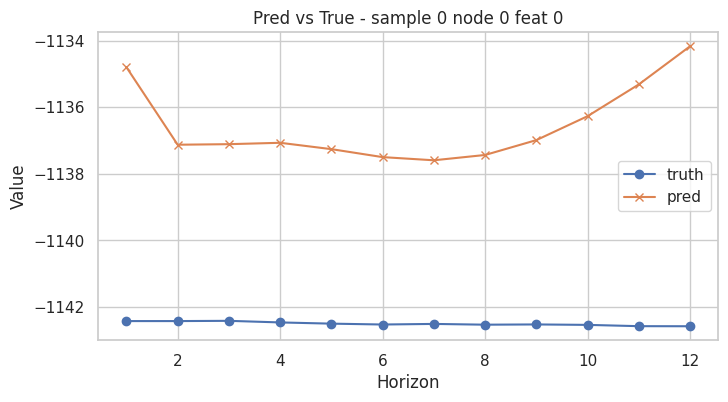

Saved figure to /home/rlara/trabajo_rl/DCRNN_predecir_adj_dina/data/student_nodes/notebook_rl/data/student_nodes/notebook_rl/figs/pred_vs_true_s0_n0_f0.png


In [6]:
# Toma ejemplos sencillos: muestra 0, nodo 0, feature 0 (ajusta si quieres explorar otros)
sample_idx = 0
node_idx = 0
feat_idx = 0
y_pred = preds[:, sample_idx, node_idx, feat_idx]
y_true = truth4[:, sample_idx, node_idx, feat_idx]
plt.figure(figsize=(8,4))
plt.plot(range(1, len(y_pred)+1), y_true, marker='o', label='truth')
plt.plot(range(1, len(y_pred)+1), y_pred, marker='x', label='pred')
plt.xlabel('Horizon')
plt.ylabel('Value')
plt.title(f'Pred vs True - sample {sample_idx} node {node_idx} feat {feat_idx}')
plt.legend()
figpath = FIGS_DIR / f'pred_vs_true_s{sample_idx}_n{node_idx}_f{feat_idx}.png'
plt.savefig(figpath, bbox_inches='tight', dpi=150)
plt.show()
print('Saved figure to', figpath)

## 7) Análisis de residuos (histograma y scatter)

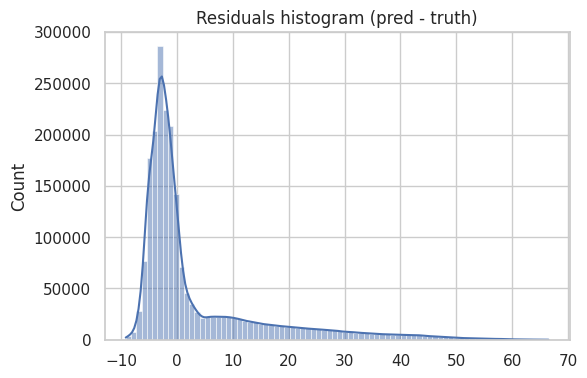

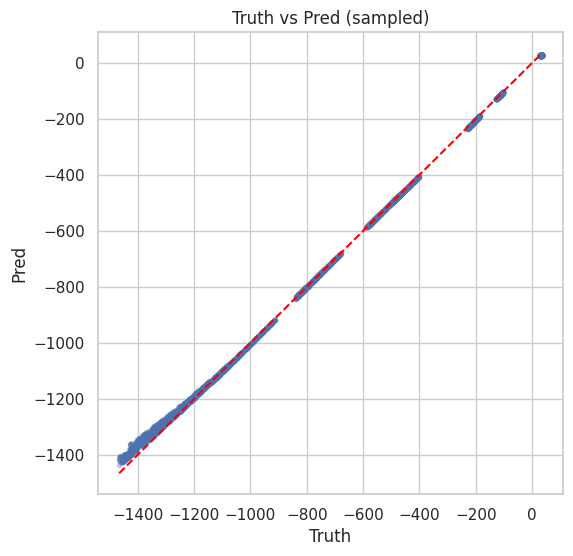

Saved residual figures to /home/rlara/trabajo_rl/DCRNN_predecir_adj_dina/data/student_nodes/notebook_rl/data/student_nodes/notebook_rl/figs/residuals_hist.png and /home/rlara/trabajo_rl/DCRNN_predecir_adj_dina/data/student_nodes/notebook_rl/data/student_nodes/notebook_rl/figs/truth_vs_pred_scatter.png


In [7]:
# Residuals: pred - truth (usar la primera feature si hay >1)
if preds.shape[-1] > 1:
    pred_flat = preds[..., 0].ravel()
    truth_flat = truth4[..., 0].ravel()
else:
    pred_flat = preds.ravel()
    truth_flat = truth4.ravel()
res = pred_flat - truth_flat
plt.figure(figsize=(6,4))
sns.histplot(res, bins=80, kde=True)
plt.title('Residuals histogram (pred - truth)')
hist_path = FIGS_DIR / 'residuals_hist.png'
plt.savefig(hist_path, bbox_inches='tight', dpi=150)
plt.show()
# Scatter truth vs pred (subsample para legibilidad)
n_points = min(5000, pred_flat.size)
idx = np.random.choice(pred_flat.size, size=n_points, replace=False)
plt.figure(figsize=(6,6))
plt.scatter(truth_flat[idx], pred_flat[idx], alpha=0.3, s=8)
mn = min(truth_flat[idx].min(), pred_flat[idx].min())
mx = max(truth_flat[idx].max(), pred_flat[idx].max())
plt.plot([mn, mx], [mn, mx], color='red', linestyle='--')
plt.xlabel('Truth')
plt.ylabel('Pred')
plt.title('Truth vs Pred (sampled)')
scatter_path = FIGS_DIR / 'truth_vs_pred_scatter.png'
plt.savefig(scatter_path, bbox_inches='tight', dpi=150)
plt.show()
print('Saved residual figures to', hist_path, 'and', scatter_path)

### **Observaciones — Qué muestran las gráficas**

**Distribución de residuos (histograma):**
- Hay un pico pronunciado cercano a 0 (muchos errores pequeños), lo que indica que la mayoría de predicciones están muy cerca del valor real.
- La distribución está claramente sesgada a la derecha (cola larga positiva): hay una fracción de errores grandes positivos (pred − truth >> 0). Es decir, en algunos casos el modelo sobreestima mucho.
- El pico parece estar levemente a la izquierda de 0 (ligera moda negativa), lo que sugiere un pequeño sesgo negativo promedio (pero la cola positiva compensa parte de la masa).
- Conclusión: buen ajuste general pero presencia de outliers/errores grandes asimétricos.

**Scatter Truth vs Pred (muestreo):**
- Los puntos se agrupan fuertemente alrededor de la línea identidad roja, lo que indica que el modelo captura la escala y la relación lineal entre truth y pred (pred ≈ truth) en la gran mayoría de casos.
- La dispersión alrededor de la línea es relativamente pequeña → baja varianza de error para la mayoría de muestras.
- Se aprecian algunos puntos fuera de la banda (estos coinciden con la cola derecha del histograma) — son los casos con gran error positivo.
- Rango de valores (eje x ~ -1400 a 0) sugiere que los targets tienen magnitud grande y negativa; el modelo reproduce esa escala.
